In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import datetime
import re

In this notebook, we will analyze the Nobel Prize Winners and draw conclusions based on the dataset.

# Data preprocessing

In [2]:
df = pd.read_csv('/kaggle/input/nobel-prize/nobel-prize-laureates.csv', sep=';', index_col=0)
df.sample(3)

,Firstname,Surname,Born,Died,Born country,Born country code,Born city,Died country,Died country code,Died city,Gender,Year,Category,Overall motivation,Motivation,Organization name,Organization city,Organization country,Geo Shape,Geo Point 2D
Id,,,,,,,,,,,,,,,,,,,,
567,David,Trimble,1944-10-15,2022-07-25,Northern Ireland,GB,Belfast,Northern Ireland,GB,Belfast,male,1998,Peace,NaN,"""for their efforts to find a peaceful solution...",NaN,NaN,NaN,NaN,NaN
435,Rita,Levi-Montalcini,1909-04-22,2012-12-30,Italy,IT,Turin,Italy,IT,Rome,female,1986,Medicine,NaN,"""for their discoveries of growth factors""",Institute of Cell Biology of the C.N.R.,Rome,Italy,"{""coordinates"": [[[[12.621267123, 35.49233633]...","42.78644501254304, 12.072389175252704"
825,Luc,Montagnier,1932-08-18,2022-02-08,France,FR,Chabris,France,FR,Paris,male,2008,Medicine,NaN,"""for their discovery of human immunodeficiency...",World Foundation for AIDS Research and Prevention,Paris,France,"{""coordinates"": [[[[55.501312696, -20.87322356...","42.182029178537626, -2.7544221494581898"


Let's pay attention that dataset consists of twenty independent variables which are:

In [3]:
df.columns.tolist()

['Firstname',
 'Surname',
 'Born',
 'Died',
 'Born country',
 'Born country code',
 'Born city',
 'Died country',
 'Died country code',
 'Died city',
 'Gender',
 'Year',
 'Category',
 'Overall motivation',
 'Motivation',
 'Organization name',
 'Organization city',
 'Organization country',
 'Geo Shape',
 'Geo Point 2D']

Our focus should be on extracting the essential columns while omitting finer details like Died country code, Organization city, Geo Point 2D, and others. 

Shortening column names contributes to a more streamlined data handling process.

In [4]:
columns_to_drop = [
    'Born country code', 'Born city', 'Died country code', 'Died city',
    'Overall motivation', 'Organization city', 'Organization country',
    'Geo Shape', 'Geo Point 2D', 'Motivation'
]

df.drop(columns=columns_to_drop, inplace=True)

shorter_column_names = {
    'Firstname': 'First',
    'Surname': 'Last',
    'Born': 'Birth',
    'Died': 'Death',
    'Born country': 'Birth_Country',
    'Died country': 'Death_Country',
    'Organization name': 'Organization'
}

df.rename(columns=shorter_column_names, inplace=True)

It looks way better than before. Although we shortened column names, we are still able to recognize each meaning easily. 

## Missing values
Now, we must ensure data integrity and reliability. It is vital for accurate analyses and conclusions.

In [5]:
def check_missing_values(column):
    nan_percentage = df[column].isnull().sum() / df[column].size
    print(f'"{column}" column consists of {nan_percentage:.2%} missing values.')

for column in df.columns:
    check_missing_values(column)

"First" column consists of 0.10% missing values.
"Last" column consists of 3.34% missing values.
"Birth" column consists of 4.04% missing values.
"Death" column consists of 33.06% missing values.
"Birth_Country" column consists of 3.13% missing values.
"Death_Country" column consists of 34.28% missing values.
"Gender" column consists of 0.00% missing values.
"Year" column consists of 0.00% missing values.
"Category" column consists of 0.00% missing values.
"Organization" column consists of 26.49% missing values.


It appears that the columns 'Death,' 'Death_Country,' and 'Organization' have quite a few missing values. Let's leave out these columns for now and come back to them later.


## Data types
Let's see the sample to gain a better understanding of the data types.

In [6]:
formatted_data = []
column_name_width = 20
column_value_width = 25

for column_name, column_value in df.loc[1].items():
    column_dtype = df[column_name].dtype
    formatted_data.append(f"{column_name.ljust(column_name_width)}{str(column_value).ljust(column_value_width)}{column_dtype}")

sample_output = "\n".join(formatted_data)
print(sample_output)

First               Wilhelm Conrad           object
Last                Röntgen                  object
Birth               1845-03-27               object
Death               1923-02-10               object
Birth_Country       Prussia (now Germany)    object
Death_Country       Germany                  object
Gender              male                     object
Year                1901                     int64
Category            Physics                  object
Organization        Munich University        object


## Refine Birth Locations

We've noticed that the 'Birth_Country' column currently contains entries indicating previous affiliations with other countries. To ensure precision, we'll focus solely on the current country of birth, excluding any information that might lead to inaccuracies.

In [7]:
def extract_country(birth_country):
    if isinstance(birth_country, str):
        match = re.search(r'\(now (.+)\)', birth_country)
        return match.group(1) if match else birth_country
    else:
        return birth_country

df['Birth_Country'] = df['Birth_Country'].apply(extract_country)

# Data Analysis

## Top Countries

What are the top countries with the highest number of Nobel laureates? 

Let's create a WordCloud to show it visually!

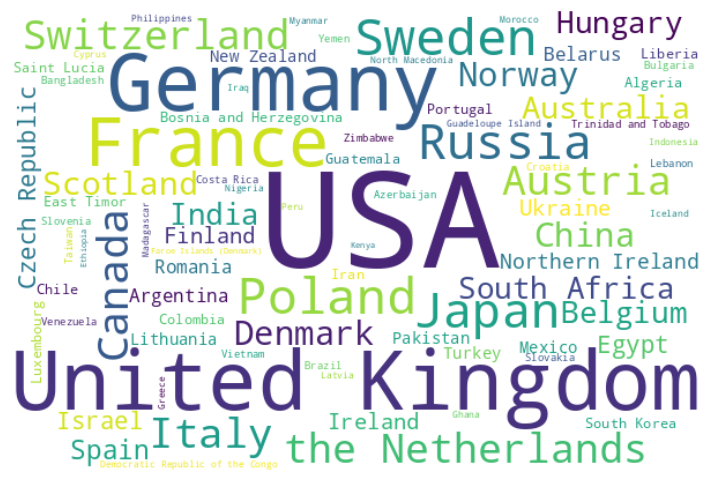

In [8]:
birth_country_series = df.value_counts('Birth_Country')

wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(birth_country_series)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

It appears that the **USA**, **United Kingdom**, **Germany**, **France** boast the most Nobel laureates.

In [9]:
birth_country_df = birth_country_series.reset_index()
birth_country_df.columns = ['Country', 'Nobelists']

fig = px.choropleth(
    birth_country_df,
    locations='Country',
    locationmode='country names',
    color='Nobelists',
    title='Nobel Prize Winners by Birth Country',
    hover_name='Country',
    color_continuous_scale= 'Plasma'
)

fig.show()

## Gender Distribution

Let's check how the Nobel Prize's gender distribution looks in each category.

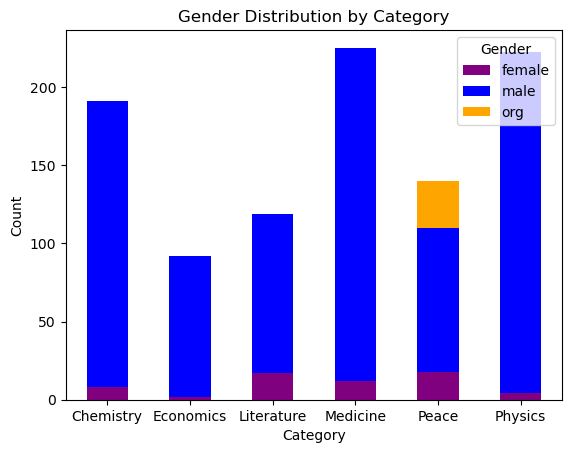

In [10]:
gender_category_counts = df.groupby(['Category', 'Gender']).size().unstack()

colors = {'female': 'purple', 'male': 'blue', 'org': 'orange'}

ax = gender_category_counts.plot(kind='bar', stacked=True, color=[colors.get(gender, 'gray') for gender in gender_category_counts.columns])

ax.set_ylabel('Count')
ax.set_title('Gender Distribution by Category')

plt.xticks(rotation=0)

plt.show()

The Nobel Prizes across all categories show a clear imbalance, with males significantly outnumbering females.

## Nobel Prize Historical Trends

How about we look into the history of Nobel Prizes and the patterns they follow?

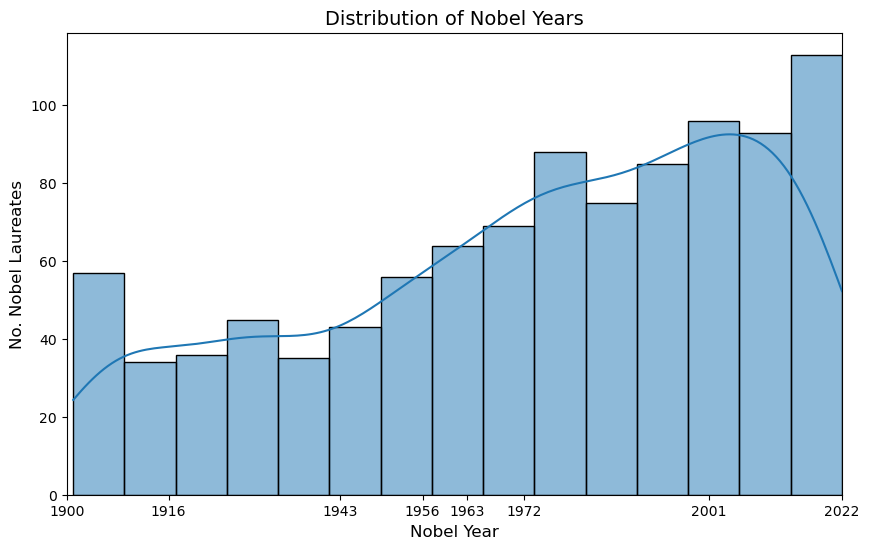

In [11]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='Year', bins=15, kde=True)

plt.xlabel('Nobel Year', fontsize=12)
plt.ylabel('No. Nobel Laureates', fontsize=12)
plt.title('Distribution of Nobel Years', fontsize=14)

plt.xticks(range(1900, 2023, 122))
additional_ticks = [1916, 1943, 1956, 1963, 1972, 2001]

plt.xticks(list(plt.xticks()[0]) + additional_ticks)

plt.xlim(1900, 2022)

plt.show()

What can we learn from this histogram about how different political events have influenced the distribution of Nobel Prizes?




Let's delve into the historical outliers – those exceptional years that I trust are familiar to you.

- **1916**: ***World War I*** (might have affected the availability of resources for research and advancements in various fields)

- **1943-1945**: ***World War II*** had a profound impact on global affairs, including research and academic activities. The war likely redirected resources and attention away from scientific pursuits, resulting in fewer notable discoveries and innovations during these years.

- **1956**: ***The post-World War II*** period marked a time of rebuilding and economic growth. This have led to increased investments in research and development, resulting in more notable achievements and Nobel laureates during this year.

- **1963**:  The early 1960s were marked by the ***Cold War*** and various social and political movements. Scientific advancements have been influenced by the growing competition between superpowers and the desire to make groundbreaking discoveries.

- **1972-1975**: These years coincide with a period of continued ***Cold War tensions***, but also various ***societal changes*** and ***movements***. The civil rights movement, environmental awareness, and other social factors have impacted the types of achievements and discoveries recognized by the Nobel Prizes.

- **2001**: This year is associated with ***the September 11 terrorist attacks***. The global response to these events have influenced research priorities and funding, affecting the scientific achievements that led to Nobel Prize recognition.

## Average Lifetime

As you might have noticed, Nobel Prize winners tend to live in times that are not very peaceful. We all know that stress isn't great for living a long life. So, on average, how long do Nobel Prize winners actually live?

For enhanced reliability in the analysis, consider treating Nobel laureates who are still living (represented as NaN values) as individuals who have reached an age equal to the difference between the current date and their year of birth. This approach ensures a more robust foundation for the analysis.

In [12]:
df_copy = df.copy()

current_date = datetime.datetime.now().date().strftime('%Y-%m-%d')
df["Death"].fillna(current_date, inplace=True)

df['Age'] = ((pd.to_datetime(df["Death"]) - pd.to_datetime(df["Birth"])).dt.days / 365.25).astype(float)

print(f'Average age of Nobel Prize winner is {df.Age.mean():.4} years. [Filled data]')

Average age of Nobel Prize winner is 80.09 years. [Filled data]


Quite an impressive age, indeed! But remember, the "Death" column had 33.06% missing values which we filled with the current date. This might affect our data and skew the average year. Let's try a different approach and see what results we get.

In this case, we'll skip any incomplete data and concentrate only on the trustworthy information.

In [13]:
df_copy = df_copy.dropna(subset=['Death', 'Birth'])

df_copy['Birth'] = pd.to_datetime(df_copy['Birth'])
df_copy['Death'] = pd.to_datetime(df_copy['Death'])

df_copy['Age'] = ((df_copy['Death'] - df_copy['Birth']).dt.days / 365.25).astype(float)

average_age_copy = df_copy['Age'].mean()

print(f'Average age of Nobel Prize winners is {average_age_copy:.4} years. [Trustworthy data]')

Average age of Nobel Prize winners is 80.83 years. [Trustworthy data]


We notice that using reliable data instead of incomplete information makes only a slight difference. We can reasonably estimate that the typical average age of Nobel Prize winners is approximately 80 years.

## Top Organizations

Which organizations boast the most Nobel laureates among their ranks?


Let's check it out!

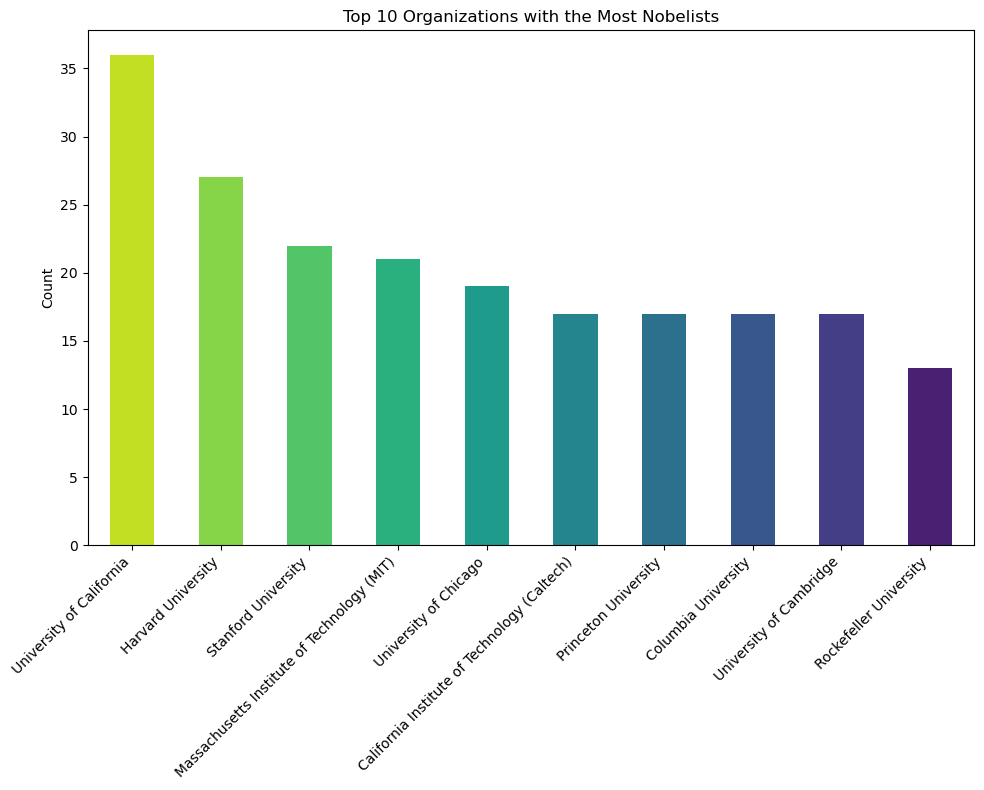

In [14]:
top_10_organizations_series = df['Organization'].value_counts().head(10)

color_palette = sns.color_palette("viridis", len(top_10_organizations_series))

top_10_organizations_series.plot(kind='bar', color=color_palette[::-1], figsize=(10, 8))

plt.title('Top 10 Organizations with the Most Nobelists')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

We can see that:
 - **University of California** stands out with the highest count of Nobel laureates, showcasing its strong contribution to various fields of research.
 - **Harvard University** comes next, underlining its role as a major hub for pioneering research.
 - **Stanford University** and **MIT** also show their strong presence.
 - **University of Chicago**, **Caltech**, **Princeton University**, **Columbia University**, and the **University of Cambridge** form a group with similar Nobel laureate counts.
 - **Rockefeller University** rounds out the list, showcasing its notable contributions.

# Conclusions

- USA, United Kingdom, Germany, and France dominate in producing Nobel laureates.
- More men have won Nobel Prizes compared to women, showing a gender gap.
- Political events have influenced Nobel distribution.
- Average Nobel winner age is around 80 years.
- The University of California is the top organization in the world that has produced the most Nobel Prize winners.